In [16]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

In [19]:
def sigmoid(Z):
    """
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """

    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)

    cache = Z 
    return A, cache

In [20]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
index = 10
#plt.imshow(train_x_orig[index])
#print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [21]:
m_train = train_x_orig.shape[0] #209
num_px = train_x_orig.shape[1]  #64
m_test = test_x_orig.shape[0]   #50

In [22]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T  
# The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
#12288=64*64*3

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255. 
test_x = test_x_flatten/255.

In [37]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    W2 = np.random.randn(n_y, n_h)*0.01
    b1 = np.zeros((n_h, 1))
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters 

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z) 
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -1./m * np.sum(Y*np.log(AL)+(1-Y)* np.log(1-AL)) 
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation =="sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db 
                                                                                                                    
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate * grads["dW" + str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate * grads["db" + str(l+1)]
    return parameters
                                                                                                                                                                                                                                    

In [40]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
        cost = compute_cost(A2, Y)
        
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dA1 ,dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0 ,dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 ==0:
            print("cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 ==0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters
     

cost after iteration 0: 0.693049735659989
cost after iteration 100: 0.6464320953428849
cost after iteration 200: 0.6325140647912677
cost after iteration 300: 0.6015024920354665
cost after iteration 400: 0.5601966311605747
cost after iteration 500: 0.5158304772764729
cost after iteration 600: 0.47549013139433255
cost after iteration 700: 0.4339163151225749
cost after iteration 800: 0.4007977536203886
cost after iteration 900: 0.3580705011323798
cost after iteration 1000: 0.3394281538366412
cost after iteration 1100: 0.3052753636196264
cost after iteration 1200: 0.2749137728213015
cost after iteration 1300: 0.24681768210614846
cost after iteration 1400: 0.19850735037466108
cost after iteration 1500: 0.17448318112556654
cost after iteration 1600: 0.17080762978096026
cost after iteration 1700: 0.1130652456216473
cost after iteration 1800: 0.09629426845937154
cost after iteration 1900: 0.08342617959726861
cost after iteration 2000: 0.07439078704319084
cost after iteration 2100: 0.0663074813

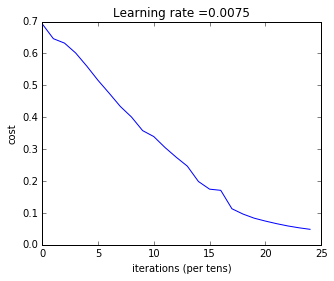

In [41]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [45]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p
#predictions_train = predict(train_x, train_y, parameters)
#predictions_test = predict(test_x, test_y, parameters)